[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/Prediction_Test_Xception_A3F1P3_vs_A3F5P3.ipynb)

In [0]:
# Import library
import os
import glob


In [0]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')
os.listdir('gdrive/My Drive/Colab')

Mounted at /content/gdrive


['Model', 'Data']

In [0]:
from keras.models import load_model

# Set model path

modelPath = 'gdrive/My Drive/Colab/Model'

dataPath = 'gdrive/My Drive/Colab/Data'

modelList = glob.glob(modelPath + '/*h5')

print(modelList)

model = load_model(modelList[0])



Using TensorFlow backend.


['gdrive/My Drive/Colab/Model/A3F1P3 vs A3F5P3 ResNet50 10-06 05:30:50.h5']


In [0]:
dataPath = 'gdrive/My Drive/Colab/Data'

foldersTest = ['A3F2P3', 'A3F3P3', 'A3F4P3']

pathTests = [dataPath + '/' + folder for folder in foldersTest]
print(pathTests)

filesTest = list()

for i in range(len(foldersTest)):
    filesTest = filesTest + (glob.glob(pathTests[i] + '/*.wav'))
    
print(len(filesTest))

['gdrive/My Drive/Colab/Data/A3F2P3', 'gdrive/My Drive/Colab/Data/A3F3P3', 'gdrive/My Drive/Colab/Data/A3F4P3']
3000


In [0]:
float(filesTest[0].split('/')[-1].split('_')[1][1:-1])

0.53805

In [0]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf

nsc = 1470
nov = nsc/2
nff = nsc

imgSize = 224

imgsTestList = list()

for i in range(len(pathTests)):

    npyTestPath = glob.glob(pathTests[i] + '/' + '*.npy')
    
    if (len(npyTestPath) == 1):
        imgsTest = np.load(npyTestPath[0])

    else:
        
        filesTest = glob.glob(pathTests[i] + '/*.wav')
        
        imgsTest = np.zeros([len(filesTest), imgSize, imgSize])

        for j in trange(len(filesTest)):
            fs, dataInt16 = wf.read(filesTest[j])
            dataFloat = dataInt16 / (2 ** 15)
            Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                               window=np.hamming(nsc), cmap='viridis')
            plt.close()
            imgsTest[j, :, :] = 10 * np.log10(Pxx[0:imgSize, :])

        np.save(pathTests[i] + '/' + foldersTest[i] + '.npy', imgsTest)

    print('Test Image Shape From {}: {}'.format(foldersTest[i], imgsTest.shape))    
    
    imgsTestList.append(imgsTest)
    
imgsTestTotal = np.vstack(imgsTestList)

print('Test Image Shape From {}: {}'.format(foldersTest, imgsTestTotal.shape))    
    

Test Image Shape From A3F2P3: (1000, 224, 224)
Test Image Shape From A3F3P3: (1000, 224, 224)
Test Image Shape From A3F4P3: (1000, 224, 224)
Test Image Shape From ['A3F2P3', 'A3F3P3', 'A3F4P3']: (3000, 224, 224)


In [0]:
trainMean = -78.09887206677996
trainStd = 9.387469562826341

# Add saving mean and std with model

testImgsNorm = (imgsTestTotal - trainMean) / trainStd

testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)


In [0]:
Y_pred = model.predict(X_test)

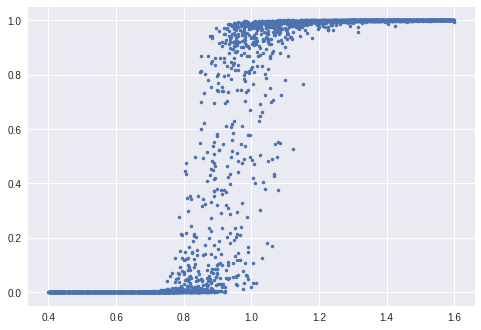

In [0]:
X_ticks = np.zeros(len(Y_pred))

for i in range(len(X_ticks)):
    X_ticks[i] = float(filesTest[i].split('/')[-1].split('_')[1][1:-1])
    

plt.plot(X_ticks, Y_pred[:, 1], '.', )

# Need to match file name with x axis

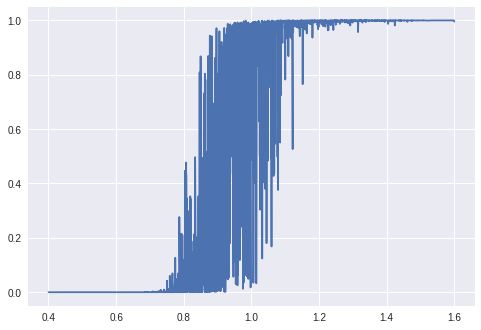

In [0]:
from operator import itemgetter

x = np.stack((X_ticks, Y_pred[:, 1])).T
y = np.asarray(sorted(x, key=lambda x: x[0]))
# plt.plot(x[:, 0], x[:, 1])
plt.plot(y[:, 0], y[:, 1])

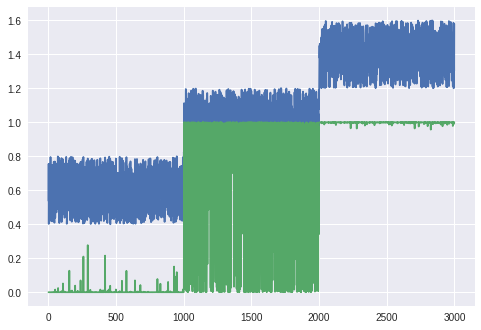

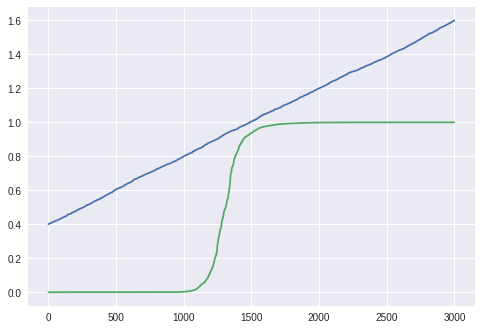

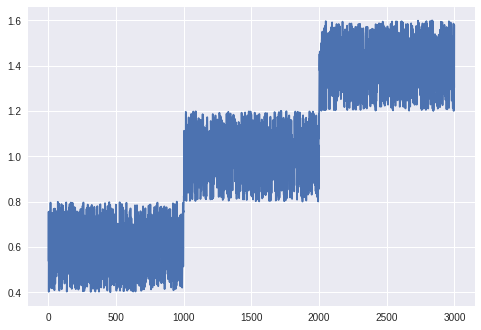

In [0]:
plt.plot(X_ticks)